In [3]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score


from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D,Convolution1D,MaxPooling1D,Conv1D,PReLU,add,Bidirectional
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D,GlobalMaxPooling1D,BatchNormalization,CuDNNGRU,CuDNNLSTM
from keras.preprocessing import text, sequence
from keras.callbacks import Callback,EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
#不全部占满显存, 按需分配
sess = tf.Session(config=config)
KTF.set_session(sess)

In [18]:
#定义超参数
MAX_SEQUENCE_LENGTH = 270
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

,contents,uid,question,tag_id,tag_name,question_answer,question_explain
0,零上 2 记作 2 零下 3 记作 2 A 2 B 3 C 3 DD ∵ 零上 2 记作 2...,323b1e899de844eeb55cf247db95694a,如果零上2℃记作+2℃那么零下3℃记作+2℃A-2℃B+3℃C-3℃DD∵零上2℃记作+2℃...,5091,数感,D,∵零上2℃记作+2℃4零下3℃记作-3℃．故答案为：D
1,九章算术 中注 ldquo 今 两算 得失 相反 要令 正负 以名 rdquo 意思 今有 ...,6e2f76e7c5824e61a7561e6fdd448e71,《九章算术》中注有ldquo今两算得失相反要令正负以名之rdquo意思是：今有两数若其意义相...,5084,运算能力,B,若气温为零上10℃记作+10℃则-3℃表示气温为零下3℃．故选B
2,足球 质量 标准 质量 相比 超出 部分 记 作 正数 不足 部分 记 作 负数 下面 4 ...,2450bfde6552451893f8a5a01281359b,若足球质量与标准质量相比超出部分记作正数不足部分记作负数．则下面4个足球中质量最接近标准的是...,5085,推理能力,C,∵|+0.8|=0.8|-3.5|=3.5|-0.7|=0.7|+2.1|=2.10.7lt...
3,下列 各对量 中 不 具有 相反 意义 胜 3 局 负 3 局 A 收入 3000 元 增加...,39e006b41a8a4cf5ba2cd37e1e9bbf1c,下列各对量中不具有相反意义的是胜3局与负3局A收入3000元与增加3000元B气温升高4℃与...,5085,推理能力,B,收入3000元与支出3000元是相反意义的量故B不符合题意．故答案为：B．
4,水位 升高 3m 时 水位 变化 记作 3m 水位 下降 3m 时 水位 变化 记 作 3m...,1fb8924413c64fc89b5df43d18e1346d,如果水位升高3m时水位变化记作+3m那么水位下降3m时水位变化记作-3mA3mB6mC-6m...,5085,推理能力,A,因为上升记为+所以下降记为-所以水位下降3m时水位变化记作-3m．故答案为：A．


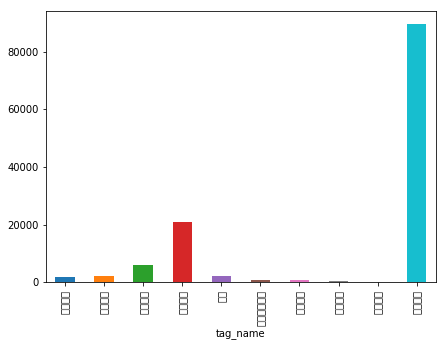

In [30]:
#读取数据，并查看每个类样本数量
data = pd.read_csv('allst_ability.csv')
import matplotlib.pyplot as plt
data.groupby('tag_name')['uid'].size().plot(kind='bar', figsize=(7, 5))
data.head()

In [25]:
#将标签名转换成唯一下标表示
le = LabelEncoder()
data['tag_name'] = le.fit_transform(data['tag_name'])

#获取训练数据与样本
trainData=data['contents']
trainLabel=data['tag_name']

In [26]:
num_labels = len(set(trainLabel))
print(num_labels)

#将样本转换成num_labels维的one-hot表示
print(type(trainLabel))
trainLabel_onehot = to_categorical(trainLabel.map(lambda x: le.transform([x])[0]), num_labels)
print(trainLabel_onehot)

10
<class 'pandas.core.series.Series'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [27]:
#生成字典，num_words:None或整数,个人理解就是对统计单词出现数量后选择次数多的前n个单词，后面的单词都不做处理。
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS,lower=False)
tokenizer.fit_on_texts(list(trainData))

# 使用字典将对应词转成index。shape为 (文档数，每条文档的长度)
sequences = tokenizer.texts_to_sequences(trainData)

# 将每个文本转成固定长度maxlen，长的截取，短的填充0
trainData_pad = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', trainData_pad.shape)

Shape of data tensor: (125460, 270)


In [28]:
# 文本中词的index映射对应的词嵌入
word_index = tokenizer.word_index

# 基于文本的词典总长为len(word_index)
num_words = min(MAX_NB_WORDS, len(word_index))

#构建权重矩阵
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
from gensim.models import word2vec
model = word2vec.Word2Vec.load('../word_embedding/word2vec_wx_300')
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(len(word_index.items()))
ss=0
for word, i in word_index.items():
    if word in model.wv.vocab:
        ss += 1
        if i >= num_words:
            break
        embedding_matrix[i] = model.wv[word]
    else:
        pass
print(embedding_matrix.shape)

166072
(20000, 300)


In [51]:
#划分训练集与测试集
X_train, X_test, Y_train, Y_test = train_test_split(trainData_pad,trainLabel_onehot,test_size=0.05, random_state=3619)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(6273, 10)


In [37]:
# TextCNN模型
def get_model():    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], EMBEDDING_DIM), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(10, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [38]:
# CONv + GRU模型

from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D,GlobalAveragePooling1D,concatenate

file_path = "best_model.hdf5"

check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

#激活函数 sigmoid多用于二分类，softmax多用于多分类
#损失函数 binary_crossentropy多用于二分类，categorical_crossentropy多用于多分类

def build_model(units=128):
    inp = Input(shape = (MAX_SEQUENCE_LENGTH,))
    x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(0.3)(x)

    x = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    y = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    y = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)
    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)

    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)

    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])
    x = Dense(10, activation = "softmax")(x)

    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ["accuracy"])
    return model

In [ ]:
# LSTM 模型
from keras.layes import LSTM
from keras.models import Sequential,Model

def build_LSTM_model():
    model=Sequential()
    model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=Flase))
    model.add(LSTM(EMBEDDING_DIM,dropout=0.2,recurrent_dropout=0.2))
    model.add(Dense(num_labels,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [ ]:
#LSTM+Attention模型
from keras.engine.topology import Layer
def build_attentionLSTM_model():
    embedding_layer = Embedding(MAX_NB_WORDS,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    l_lstm = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True))(embedded_sequences)
    l_att = AttLayer()(l_lstm)
    preds = Dense(num_labels, activation='softmax')(l_att)
    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
# Attention GRU network
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        #self.input_spec = [InputSpec(ndim=3)]
        super(AttLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        assert len(input_shape)==3
        #self.W = self.init((input_shape[-1],1))
        self.W = self.init((input_shape[-1],))
        #self.input_spec = [InputSpec(shape=input_shape)]
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape) # be sure you call this somewhere!
    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x, self.W))
        ai = K.exp(eij)
        weights = ai/K.sum(ai, axis=1).dimshuffle(0,'x')
        weighted_input = x*weights.dimshuffle(0,1,'x')
        return weighted_input.sum(axis=1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
#LSTM+Attention 2 模型
from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        #regularizers:正则化器允许在优化过程中对层的参数或层的激活情况进行惩罚。 
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        #constraints 模块的函数允许在优化期间对网络参数设置约束（例如非负性）,约束是以层为对象进行的。约束层开放 2 个关键字参数：
        #kernel_constraint 用于主权重矩阵。
        #bias_constraint 用于偏置。

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3  #断言，如果input_shape长度不为3就报错
        #输入形状：（samples:样本数 批量处理的数目 ， step_dim:样本长度 限定文本的最大长度 ，embedding_dim:词向量长度）
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano ; 
            #cast:将张量转换到不同的 dtype 并返回。
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        #epsilon() 返回一个很小的浮点数，以防止除0错误
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        #expand_dims,在dim的轴上增加一维，dim默认为-1  [1,2,3]->[[1]
#                                                               [2]
#                                                               [3]]
        a = K.expand_dims(a)
        weighted_input = x * a
        #print weigthted_input.shape
        #列方向求和
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        #返回：（样本数(sample)，样本长度（step_dim））
        return input_shape[0],  self.features_dim
def getModel():
    rate_drop_lstm = 0.25
    rate_drop_dense = 0.25

    embedding_layer = Embedding(MAX_NB_WORDS,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

    lstm_layer = LSTM(EMBEDDING_DIM, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm,return_sequences=True)

    comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences= embedding_layer(comment_input)
    x = lstm_layer(embedded_sequences)
    x = Dropout(rate_drop_dense)(x)
    merged = Attention(MAX_SEQUENCE_LENGTH)(x)
    merged = Dense(num_dense, activation=act)(merged)
    merged = Dropout(rate_drop_dense)(merged)
   # BatchNormalization 批量标准化层 即，应用一个维持激活项平均值接近 0，标准差接近 1 的转换。
    merged = BatchNormalization()(merged)
    preds = Dense(num_labels, activation='sigmoid')(merged)

    ########################################
    ## train the model
    ########################################
    model = Model(inputs=[comment_input], outputs=preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    print(model.summary())
    return model

In [39]:
# 定义训练参数
filter_sizes = [1,2,3,5]
num_filters = 32
batch_size = 256
epochs = 10
# model=get_model()

model = build_model()


In [42]:
#自定义每个类别权重
class_dict = {9:1,3:3,2:9,4:21,1:22,0:26,6:50,5:60,7:80,8:150}

## 建立字典，设置不同的采样权重
resample_dict = {8:800,7:1200,5:1600,6:1800,0:3400,1:4000,4:4242}

# 进行采样
bsm = BorderlineSMOTE(sampling_strategy=resample_dict, random_state=42)
# bsm = BorderlineSMOTE(random_state=42)
#X_res, y_res = x_train, y_train
print(len(X_train),len(Y_train))
X_res, y_res = bsm.fit_resample(X_train, Y_train)

119187 119187


In [46]:
#划分训练与验证集，random_state可调
X_tra, X_val, y_tra, y_val = train_test_split(X_res,y_res, train_size=0.95, random_state=2018)

#训练
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs,class_weight=class_dict, validation_data=(X_val, y_val), verbose=2)

Train on 121523 samples, validate on 6396 samples
Epoch 1/10
 - 54s - loss: 0.7447 - acc: 0.9128 - val_loss: 0.2306 - val_acc: 0.9048
Epoch 2/10
 - 54s - loss: 0.7439 - acc: 0.9131 - val_loss: 0.2404 - val_acc: 0.9015
Epoch 3/10
 - 54s - loss: 0.7307 - acc: 0.9127 - val_loss: 0.2308 - val_acc: 0.9050
Epoch 4/10
 - 54s - loss: 0.7250 - acc: 0.9130 - val_loss: 0.2463 - val_acc: 0.9007
Epoch 5/10
 - 54s - loss: 0.7193 - acc: 0.9133 - val_loss: 0.2359 - val_acc: 0.9046
Epoch 6/10
 - 54s - loss: 0.7094 - acc: 0.9135 - val_loss: 0.2265 - val_acc: 0.9087
Epoch 7/10
 - 54s - loss: 0.6925 - acc: 0.9141 - val_loss: 0.2444 - val_acc: 0.9039
Epoch 8/10
 - 54s - loss: 0.6929 - acc: 0.9141 - val_loss: 0.2610 - val_acc: 0.8966
Epoch 9/10
 - 54s - loss: 0.6834 - acc: 0.9147 - val_loss: 0.2378 - val_acc: 0.9071
Epoch 10/10
 - 54s - loss: 0.6784 - acc: 0.9144 - val_loss: 0.2376 - val_acc: 0.9054


In [54]:
#预测
y_pred = model.predict(X_test, batch_size=batch_size)

#调整结果格式
top = np.argsort(-model.predict(X_test), axis=1)[:, :1]
result=[]
for r in top:
    result.append(r[0])
Y_test = np.argmax(Y_test, axis=1)   
Y_test=np.asarray(Y_test)
result=np.asarray(result)


0.5260640841702535

In [ ]:
#正确率
# acc = accuracy_score(Y_test,np.argmax(y_pred, axis=1))
acc = accuracy_score(Y_test,result)
acc

In [56]:
#f1值
score_cv = f1_score(Y_test, result, labels=range(0, 10), average='weighted')
score_cv

0.592977871621184